# Data Scraping in R
## MSDS 7333 - Section 401
## Case Study Week 8
[Data Science @ Southern Methodist University](https://datascience.smu.edu/)

### Due:
02 July 2018

### Table of Contents
* [Team Members](#Team-Members)
* [Abstract](#Abstract)
* [Introduction](#Introduction)
* [Methods](#Methods)
* [Results](#Results)
* [Conclusion](#Conclusion)
* [References](#References)

### <a name="Team-Members"></a>Team Members
* Kevin Cannon
* Austin Hancock

### <a name="Abstract"></a>Abstract

Use annual race results from the Cherry Blossom 10-mile race in Washington, D.C. as a target for web scraping techniques in R. Correctly locate, pull, clean, and format the race results for the female runners for the years 1999 through 2012. Final product will be dataframes ready for analysis. This notebook answers [Exercise #2.7](http://www.rdatasciencecases.org/exercises.html#chap:CherryBlossom) in the Nolan and Lang reference.

### <a name="Introduction"></a>Introduction

When working with data, having to perform some sort of maintenance on the data is a given. Whether it is a simple type change (i.e. character to numeric), or perhaps something more sinister like decyphering table data stored in an AS400 database which has a limit on column name length making them less than informative. Whatever the data source may be, you will need to do some cleaning to get the data into workable condition. 

Not all data will come from structured databases. Sometimes it will be neccessary to locate information from the web and pull that data into a workable format; this is called web scraping. 

This lab will be exploring web scraping techniques using the R programming language. Our target dataset will be annual race results from the Cherry Blossom 10-mile race in Washington, D.C which can be found at http://www.cherryblossom.org/. Originally a precursor training run for runners competing in the Boston Marathon, the race that started in 1973 has now grown in popularity and hosts runners of all ages and levels. The race is scheduled for the first Sunday in April each year to align wth the bloom of the cherry blossoms near the Tidal Basin and East Potomac Park. Currently, published race results span the years 1999 through 2012. While the data is available publically, the task of scraping and formatting the race results can be a challenge due to odd formatting choices and errors from year to year. To create a useable dataset, an iterative process will be used to find, then correct small errors throughout the race results.

For this analysis, we will be using the public data from historical race results to read and process the files for the female runners into data frames which could be used for analysis. The analysis in this case study follows the analysis in the Nolan and Lang [1] textbook, where the authors analyzed and cleaned data from the male race results over the years. The focus of the lab will be to scrape and format the data for the female runners properly. Specifically, the lab centers around [Exercise #2.7](http://www.rdatasciencecases.org/exercises.html#chap:CherryBlossom), which has the following instructions:
> Follow the approach developed in the section called “Reading Tables of Race Results into R” to read the files for the female runners and then process them using the functions in the section called “Data Cleaning and Reformatting variables” to create a data frame for analysis. You may need to generalize the createDF() and extractVariables() functions to handle additional oddities in the raw text files.

### <a name="Methods"></a>Methods

Our web scraping process was performed in three stages: locate and scrape the data from the web, read the data into R, and clean and format the data into data frames. Below, we explore each step further.

#### Locate and Scrape Data

To begin, we first located the site from which we would be pulling our data. Finding the data you want to use from a site can sometimes be the most difficult part when working with unstructured web data, however, this site was easy to navigate and the race results we were after could be found by following a link on the main page menu. Unfortunately, there is not a consistent format to the URLs of the results between different years and genders. With no easy programmatic solution to finding the correct URLs, we had to manually visit each page of results. Since most of the variation in the URLs occured after the "results" folder, the main URL was stored as a base in order to aid with extraction. To pull the data from each page, we stored all of the URL extensions after "results" in a vector, and then appended each extension to the base URL. This process gave us the full path to each of the annual race result pages we will be pulling.

In [2]:
# Load XML library.
library(XML)

# Set variable for the web page we will use for extraction.
ubase = "http://www.cherryblossom.org/"

# Create a vector with the web pages that the race data is on.
womenURLs = c(
    "results/1999/cb99f.html",
    "results/2000/Cb003f.htm",
    "results/2001/oof_f.html",
    "results/2002/ooff.htm", 
    "results/2003/CB03-F.HTM",
    "results/2004/women.htm", 
    "results/2005/CB05-F.htm", 
    "results/2006/women.htm", 
    "results/2007/women.htm", 
    "results/2008/women.htm", 
    "results/2009/09cucb-F.htm",
    "results/2010/2010cucb10m-f.htm", 
    "results/2011/2011cucb10m-f.htm",
    "results/2012/2012cucb10m-f.htm"
)

# Append the web pages to the site and store.
# This produces the full url.
urls = paste(ubase, womenURLs, sep = "")

Warning message:
"package 'XML' was built under R version 3.4.4"

Having the location of our files, we investigated each year to determine how the data would need to be handled in order to correctly pull the information. From initial inspection, the data are found to be formatted in blocks of plain text arranged in fixed-width columns.

In order to read the data into R later, we needed to write the page data into text files. The function below is generalized to handle both male and female race data for any year. As is common with any actively curated dataset, there are differences among the files. To account for these formatting differences, conditional statements were added to the function to account for specific anomalies. Using the htmlParse() function in the XML package, we are able to scrape the plain text tables within < pre > nodes in an HTML document.

In [3]:
# Function to pull data.
# Contains specific instances where unique formatting was used
extractResTable =
  #
  # Retrieve data from web site, 
  # find the preformatted text,
  # and write lines or return as a character vector.
  #
  function(url = "http://www.cherryblossom.org/results/2009/09cucb-F.htm",
           year = 1999, sex = "female", file = NULL)
  {
    doc = htmlParse(url)

    if (year == 2000) {
      # Get preformatted text from 4th font element
      # The top file is ill formed so the <pre> search doesn't work.
      ff = getNodeSet(doc, "//font")
      txt = xmlValue(ff[[4]])
      els = strsplit(txt, "\r\n")[[1]]
    }
    else if (year == 2009 & sex == "male") {
      # Get preformatted text from <div class="Section1"> element
      # Each line of results is in a <pre> element
      div1 = getNodeSet(doc, "//div[@class='Section1']")
      pres = getNodeSet(div1[[1]], "//pre")
      els = sapply(pres, xmlValue)
    }
     else if (year == 1999) {
               # Get preformatted text from <pre> elements
      pres = getNodeSet(doc, "//pre")
      txt = xmlValue(pres[[1]])
      els = strsplit(txt, "\n")[[1]]  
     } 
    else {
      # Get preformatted text from <pre> elements
      pres = getNodeSet(doc, "//pre")
      txt = xmlValue(pres[[1]])
      els = strsplit(txt, "\r\n")[[1]]   
    } 
    
    if (is.null(file)) return(els)
    # Write the lines as a text file.
    writeLines(els, con = file)
  }

We then applied the function to each url and saved to the variable 'womenTables' to be used for reading the data into R. Below, you can see the line counts for each year. Based on this initial display, it appears that the number of female runners generally increases each year of the race. However, more exploration will need to be done in R before we can be sure of that result. 

In [4]:
years = 1999:2012
womenTables = mapply(extractResTable, url = urls, year = years)
names(womenTables) = years
sapply(womenTables, length)
save(womenTables, file = "CBWomenTextTables.rda")

1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 
2359 2169 2976 3338 3547 3907 4342 5445 5699 6405 8333 8863 9038 9738

#### Read Data Into R

Having scraped all files from the web, we will now read the data into R. To do this, we first create a local folder into which we write our text files of the race results. Then, we write each year into a text file, stored by year in the new folder. Finally, we take a look at the first few rows of a file to see what we will need to do to properly format the data so that all files can be handled with a single generalized function.

In [5]:
# Create folder to store text files
dir.create(file.path(getwd(), "WomenTxt"))

# Write each year into a text file in the new folder
write(x=womenTables$'2012',file="WomenTxt/2012.txt")
write(x=womenTables$'2011',file="WomenTxt/2011.txt")
write(x=womenTables$'2010',file="WomenTxt/2010.txt")
write(x=womenTables$'2009',file="WomenTxt/2009.txt")
write(x=womenTables$'2008',file="WomenTxt/2008.txt")
write(x=womenTables$'2007',file="WomenTxt/2007.txt")
write(x=womenTables$'2006',file="WomenTxt/2006.txt")
write(x=womenTables$'2005',file="WomenTxt/2005.txt")
write(x=womenTables$'2004',file="WomenTxt/2004.txt")
write(x=womenTables$'2003',file="WomenTxt/2003.txt")
write(x=womenTables$'2002',file="WomenTxt/2002.txt")
write(x=womenTables$'2001',file="WomenTxt/2001.txt")
write(x=womenTables$'2000',file="WomenTxt/2000.txt")
write(x=womenTables$'1999',file="WomenTxt/1999.txt")

# Visualize what the text files look like when read
lines2012 = readLines("WomenTxt/2012.txt")
lines2012[1:10]
lines2011 = readLines("WomenTxt/2011.txt")
lines2011[1:10]

[1] ""                                                                                                
 [2] "                 Credit Union Cherry Blossom Ten Mile Run"                                       
 [3] "                 Washington, DC     Sunday, April 1, 2012"                                       
 [4] ""                                                                                                
 [5] "               Female Official Results (Sorted By Net Time)"                                     
 [6] ""                                                                                                
 [7] "Place Div  /Tot   Num    Name                   Ag Hometown             5 Mile  Time    Pace  S "
 [8] "===== =========== ====== ====================== == ==================== ======= ======= ===== = "
 [9] "    1     1/2781       2 Jelliah Tinega         26 Kenya                  26:48   54:02  5:25 ! "
[10] "    2     2/2781      24 Malika Mejdoub         29 Ethiopia               27:09   54:24  5:27 ! "

[1] ""                                                                                                        
 [2] "                 Credit Union Cherry Blossom Ten Mile Run"                                               
 [3] "                 Washington, DC     Sunday, April 3, 2011"                                               
 [4] ""                                                                                                        
 [5] "               Female Official Results (Sorted By Net Time)"                                             
 [6] ""                                                                                                        
 [7] "Place Div  /Tot   Num    Name                   Ag Hometown             5 Mile  Time    Net Tim Pace  S "
 [8] "===== =========== ====== ====================== == ==================== ======= ======= ======= ===== = "
 [9] "    1     1/2706      14 Julliah Tinega         25 Kenya                          54:02   54:02  5:25 ! "
[10] "    2     1/937       16 Risper Gesabwa         22 Kenya                  27:17   54:03   54:03  5:25 ! "

> Reading the lines of the different text files is the best way to find general formatting issues within all of the files or specific differences between files that will need to be addressed. For example, we look at the first ten lines of the 2011 and 2012 text files above, and we see that both files contain header rows and a row of '=' seperating the header and data rows. There is also a difference in variables between the years; 2011 has 'Time' and 'Net Time' while 2012 only has 'Time'. Issues like these need to be addressed in order to properly read in the files.

By looking at the lines of the text files, we can determine how best to seperate out the columns. To do this, we create a function to find the column locations by looking for spaces within a given row (this will be the row of '=' that seperates the header and data). We also create a function to handle changes within column names from year to year by selecting columns by name. This function acts like a wildcard in that it allows us to pass in only the first few characters of a column, making it more flexible. Finally, we wrap these two new functions inside of a third function that will locate the starting and ending line positions of the variables in each file.

In [6]:
findColLocs = function(spacerRow) {

  spaceLocs = gregexpr(" ", spacerRow)[[1]]
  rowLength = nchar(spacerRow)

  if (substring(spacerRow, rowLength, rowLength) != " ")
    return( c(0, spaceLocs, rowLength + 1))
  else return(c(0, spaceLocs))
}

# Create function to extract specific cols from the data tables
selectCols = 
function(colNames, headerRow, searchLocs) 
{
  sapply(colNames, 
         function(name, headerRow, searchLocs)
         {
           startPos = regexpr(name, headerRow)[[1]]
           if (startPos == -1) 
             return( c(NA, NA) )
    
           index = sum(startPos >= searchLocs)
           c(searchLocs[index] + 1, searchLocs[index + 1] - 1)
         },
         headerRow = headerRow, searchLocs = searchLocs )
}

extractVariables = 
  function(file, varNames =c("name", "home", "ag", "gun",
                             "net", "time"))
{
       # Find the index of the row with =s
  eqIndex = grep("^===", file)
       # Extract the two key rows and the data
  spacerRow = file[eqIndex] 
  headerRow = tolower(file[ eqIndex - 1 ])
  body = file[ -(1 : eqIndex) ]
       
       # Obtain the starting and ending positions of variables
  searchLocs = findColLocs(spacerRow)
  locCols = selectCols(varNames, headerRow, searchLocs)

  Values = mapply(substr, list(body), start = locCols[1, ], 
                  stop = locCols[2, ])
  colnames(Values) = varNames
  
  invisible(Values)
}

In order to apply the new function to the files, we need to read the lines of each text file first. This gives us character matrices for each year. The row counts for these matrices are shown below.

An interesting note: the 2001 women's text file does not have a header rows. To allow for the correct reading of this file, we simply copied the header rows from the Men's 2001 text file and applied them to the Women's file. A programmatic solution in R to insert the missing header rows in other text files presents an opportunity for further investigation.

In [8]:
wfilenames = paste("WomenTxt/", 1999:2012, ".txt", sep = "")
womenFiles = lapply(wfilenames, readLines)
names(womenFiles) = 1999:2012

womenResMat = lapply(womenFiles, extractVariables)
sapply(womenResMat, nrow)

1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 
2356 2167 2973 3335 3544 3899 4334 5437 5692 6397 8325 8855 9030 9730

> In comparing these row counts with those of the intial scraped data row counts, you will see that the difference matches the removal of the header rows. This is the desired result.

#### Clean and Format

With our scraped data now contained with character matrices in R, we are ready clean and format the data into data frames. The first variable we will address is 'age'. Like all variables at this point, 'age' is a character data type. Below we convert the variable to numeric and create a boxplot to investigate the interaction between it and the variable 'year'.

Warning message in FUN(X[[i]], ...):
"NAs introduced by coercion"Warning message in FUN(X[[i]], ...):
"NAs introduced by coercion"Warning message in FUN(X[[i]], ...):
"NAs introduced by coercion"

null device 
          1

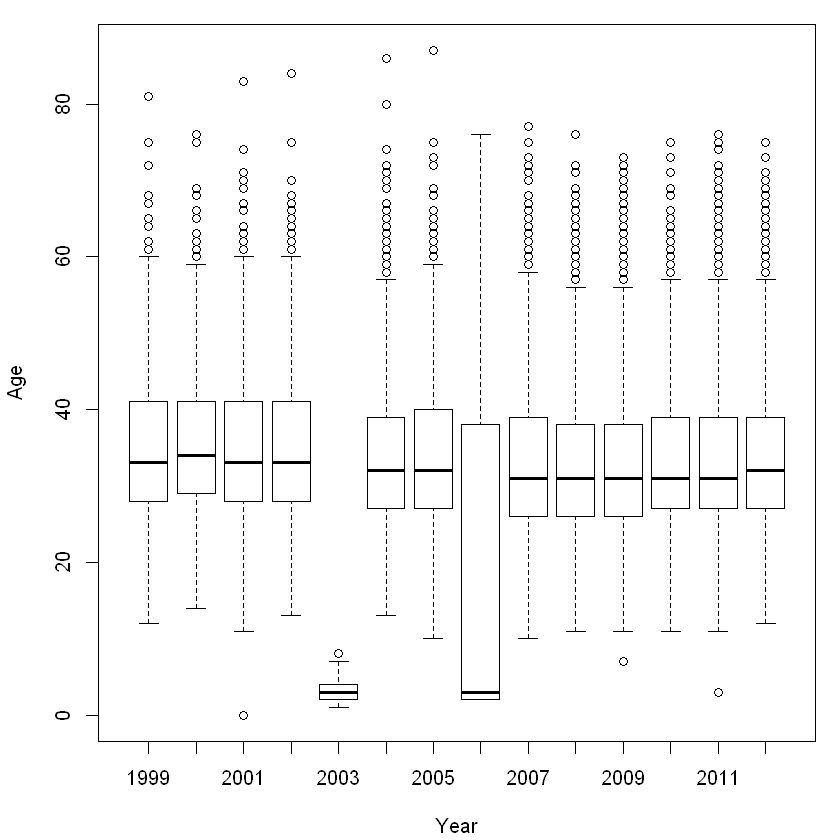

In [9]:
# Convert to numeric
age = sapply(womenResMat,
             function(x) as.numeric(x[ , 'ag']))

# Boxplot
oldPar = par(mar = c(4.1, 4.1, 1, 1))
boxplot(age, ylab = "Age", xlab = "Year") 
par(oldPar)
dev.off()          

> Plots like this are invaluable when verifying the accuracy of underlying assumptions. The box plots show that the 2003 and 2006 files appear to have issues with the Age column.

To investigate the cause of the apparent error within these two files, we will take a look at the first few lines of the text file. The output of the first few lines of the 2003 file shows that some values do not properly align with the spaces in the '=' that we used to define where columns begin and end. We modify the function used to determine the column locations to correct this spacing issue.

In [20]:
head(womenFiles[['2003']])

# Need to modify function to account for this
selectCols = function(shortColNames, headerRow, searchLocs) {
  sapply(shortColNames, function(shortName, headerRow, searchLocs){
    startPos = regexpr(shortName, headerRow)[[1]]
    if (startPos == -1) return( c(NA, NA) )
    index = sum(startPos >= searchLocs)
    c(searchLocs[index] + 1, searchLocs[index + 1])
  }, headerRow = headerRow, searchLocs = searchLocs )
}

[1] ""                                                                                             
[2] "Place Div /Tot  Num    Name                          Ag Hometown            Gun Tim  Net Tim "
[3] "===== ========= ===== ============================= == =================== =======  ======= " 
[4] "    1    1/2510  6014  Olga Romanova                 22  RUS                  53:43#   53:42 "
[5] "    2    2/2510  6004  Asha Gigi                     30  ETH                  53:49#   53:49 "
[6] "    3    3/2510  6003  Sylvia Mosqueda               36 Los Angeles CA        53:58#   53:57 "

With the adjustments to the functions made, we replot our age and year variables.

Warning message in FUN(X[[i]], ...):
"NAs introduced by coercion"Warning message in FUN(X[[i]], ...):
"NAs introduced by coercion"Warning message in FUN(X[[i]], ...):
"NAs introduced by coercion"

null device 
          1

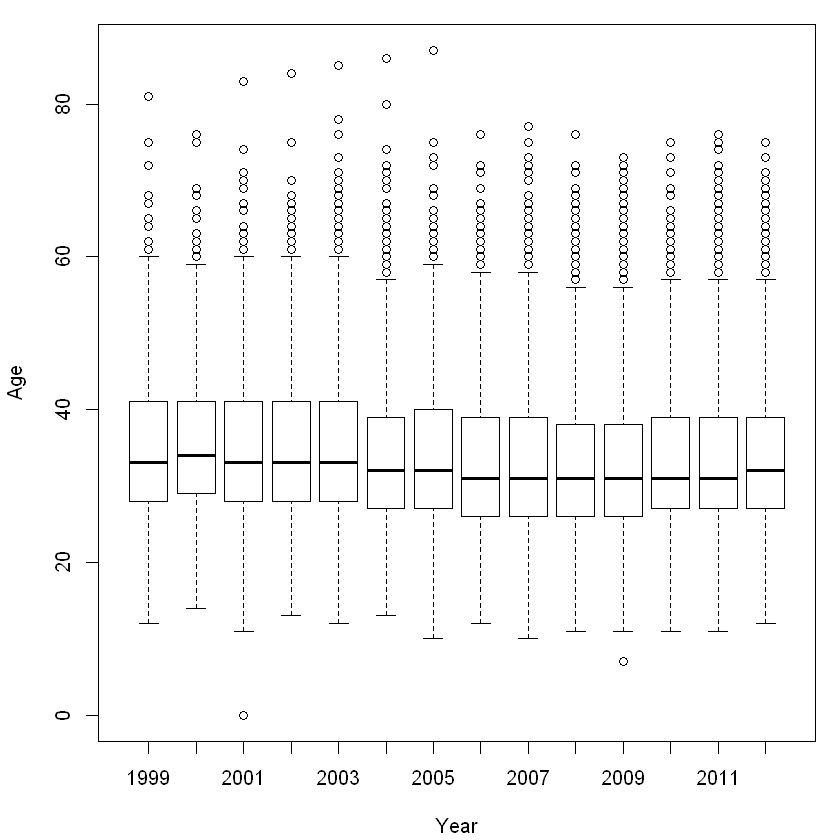

In [21]:
# Re-run boxplots using the modified selectCols function from above.
womenResMat = lapply(womenFiles, extractVariables)

age = sapply(womenResMat, 
             function(x) as.numeric(x[ , 'ag']))

# Boxplot
oldPar = par(mar = c(4.1, 4.1, 1, 1))
boxplot(age, ylab = "Age", xlab = "Year")
par(oldPar)
dev.off()

> The box plots show that the issues with the 2003 and 2006 files appear to have been resolved with the Age column.

Boxplots can also reveals points that should not be possible. Our new boxplot reveals a point that would indicate a runner with an age of 0. Below, we investigate this apparent error. We first locate the runner from 2001 indicated by our outlier of age 0. The runner is identified as Loretta Cuce. A search of this runner reveals that she has competed in this race 6 times (1996-2002, skipped 2000). Ages are provided for all years except 2001. Using this information, we can update this runner with the correct age for 2001 (55).

In the future, a programmatic solution in R to perform searches for runner information on the Cherry Blossom web page presents an opportunity for further investigation. Similar methods can be used for other missing values.

In [27]:
age2001 = age[["2001"]]
which(age2001 < 5)
womenFiles[['2001']][ which(age2001 < 5) + 5]

[1] 2611

[1] " 2611  9747 Loretta CUCE           0 Alexandria VA      1:53:38 1:54:39"

The next variable that we need to address is time. From the text files, we see that the data is formatted as hh:mm:ss and is of type character. To be able to work with the variable we will need to first split the variable into hours, minutes, and seconds using strsplit (string split). Once we have our times segmented, we will convert them to numeric and create a function to aggregate the segments to total minutes.

We then write a function to create data frames for all of the women's race results. This new function (createDF) converts time to the proper format, handles a footnote symbol that occurs for some time variables, and exports the results to a data frame.

In [41]:
convertTime = function(time) {
  timePieces = strsplit(time, ":") # split hh:mm:ss into time segments
  timePieces = sapply(timePieces, as.numeric) # Convert from char to num
  sapply(timePieces, function(x) {
                      if (length(x) == 2) x[1] + x[2]/60
                      else 60*x[1] + x[2] + x[3]/60
                      }) # Aggregate to total minutes
}

# Modify function to eliminate footnote symbols (# and *) from the times 
# and drop records of runners who did not finish the race
createDF = function(Res, year, sex) 
{
  # Determine which time to use
  if ( !is.na(Res[1, 'net']) ) useTime = Res[ , 'net']
  else if ( !is.na(Res[1, 'gun']) ) useTime = Res[ , 'gun']
  else useTime = Res[ , 'time']
  
  # Remove # and * and blanks from time
  useTime = gsub("[#\\*[:blank:]]", "", useTime)
  runTime = convertTime(useTime[ useTime != "" ])
  
  # Drop rows with no time
  Res = Res[ useTime != "", ]
  
  Results = data.frame(year = rep(year, nrow(Res)),
                       sex = rep(sex, nrow(Res)),
                       name = Res[ , 'name'], home = Res[ , 'home'],
                       age = as.numeric(Res[, 'ag']), 
                       runTime = runTime,
                       stringsAsFactors = FALSE)
  invisible(Results)
}

# Fix for 2006
separatorIdx = grep("^===", womenFiles[["2006"]])
separatorRow = womenFiles[['2006']][separatorIdx]
separatorRowX = paste(substring(separatorRow, 1, 63), " ", 
                      substring(separatorRow, 65, nchar(separatorRow)), 
                      sep = "")
womenFiles[['2006']][separatorIdx] = separatorRowX

# Apply function to all women files
womenResMat = sapply(womenFiles, extractVariables)
womenDF = mapply(createDF, womenResMat, year = 1999:2012,
               sex = rep("F", 14), SIMPLIFY = FALSE)

# Verify
womenDF[1]

Warning message in lapply(X = X, FUN = FUN, ...):
"NAs introduced by coercion"Warning message in data.frame(year = rep(year, nrow(Res)), sex = rep(sex, nrow(Res)), :
"NAs introduced by coercion"Warning message in lapply(X = X, FUN = FUN, ...):
"NAs introduced by coercion"Warning message in data.frame(year = rep(year, nrow(Res)), sex = rep(sex, nrow(Res)), :
"NAs introduced by coercion"

year,sex,name,home,age,runTime
1999,F,Jane Omoro,Kenya,26,53.61667
1999,F,Jane Ngotho,Kenya,29,53.63333
1999,F,Lidiya Grigoryeva,Russia,NA,53.66667
1999,F,Eunice Sagero,Kenya,20,53.91667
1999,F,Alla Zhilyayeva,Russia,29,54.13333
1999,F,Teresa Wanjiku,Kenya,24,54.16667
1999,F,Elana Viazova,Ukraine,38,54.48333
1999,F,Gladys Asiba,Kenya,NA,54.83333
1999,F,Nnenna Lynch,Concord MA,27,55.65000
1999,F,Margaret Kagiri,Kenya,30,55.71667


### <a name="Results"></a>Results

Through this analysis, we were able to locate, pull, clean, and format the race results for the female runners of the Cherry Blossom Race successfully. This data was formatted into an R dataframe, which can now be used for further data analysis.

Once the data is properly formatted and the values have been corrected, the data frame can be analyzed for trends and to pull meaning from the information. Until then, the data is nearly unusable in a programmatic way. 

A major difficulty for this lab was in the uniqueness of each text file of race results. While the same types of information were recorded each year, the differences in how the information was displayed in the plain text files presented challenges to systematically scraping and cleaning the data. Critical anchor points in the files, such as header rows, were not consistent in the files from year to year or even male to female. Simply accessing the data on the results webpages, the first step in any sort of web scraping, was made more difficult with inconsistent and nonsensical URLs. Even more, slightly shifted characters and added footnotes left files dissimilar enough to cause problems. Without obvious repeating patterns in any aspect of the plain text data files, scraping the data programmatically was a challenge that required adjustments on a case-by-case basis.

To address the various problems encountered from the beginning of the web scraping process, an iterative approach was used to address each unique situation and ensure all the data was extracted correctly. Adjustments were made in the processing of information to account for the particular oddities in the files, and then the data was reprocessed. As one data anomaly was resolved, it would often bring to focus another, smaller data inconsistency.

Regarding the data itself, the numeric values were cleaned last. The age values were shifted a few characters in some of the files, causing glaring issues to the age statistics. Fortunately, large discrepancies, like dropping an entire digit off of an age, are easily noticed in boxplots depicting the age distribution. The race completion time, on the other hand, was relatively consistent throughout the files. The time, in mixed units of hours, minutes, and seconds, was converted to minutes for ease of analysis. 


### <a name="Conclusion"></a>Conclusion

From the published results on the Cherry Blossom 10-mile Race website, we were able to scrape plain text data and create an R data frame for analysis. Using the Nolan and Lang code as a reference, we were able to generalize the createDF() and extractVariables() functions to handle the additional oddities in the raw text files from the women's race results.

When working with unstructured data, or data that has a shifting structure due to loose curation rules, having flexible functions will make handling any surprises much easier. Another way to make a more robust web scraper when working with this dataset would be to create a function to handle missing age data by checking to see if the runner has competed in other years and then programmatically filling in the missing data. Finally, adding constraints to certain variables that would alert us when a rule has been violated would allow for quicker detection without the need to look at box plots. For example, if the rules state that competitors must be at least 10 years old to compete, we would place a constraint on the age column to raise a warning if age is less than 10. These are just some ways in which web scraping can be made easier.

Further studies in web scraping and data cleaning could include a programmatic solution to detect and insert missing header rows into plain text files. Similarly, future work could include a programmatic solution to search and match runners with missing information to historical data.

### <a name="References"></a>References

[1] Nolan, D, and D.T. Lang. Data Science in R: A Case Studies Approach to Computational Reasoning and Problem Solving. CRC Press, 2015, books.google.com.sa/books?id=r_0YCwAAQBAJ.